In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import pi, sqrt
from scipy.special import erf 
import os

In [3]:
cnot = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])+0j

def pauli(s):
    s0 = np.matrix([[1.,0.],[0.,1.]])
    s1 = np.matrix([[0.,1.],[1.,0.]])
    s2 = np.matrix([[0.,-1.j],[1.j,0.]])
    s3 = np.matrix([[1.,0.],[0.,-1.]])
    if s == 'I':
        return s0 
    elif s =='X':
        return s1
    elif s == 'Y':
        return s2
    elif s == 'Z':
        return s3
    
def pauli_str_to_mat(string):
    U = pauli(string[0])
    for k in range(1,len(string)):
        U =np.kron(U, pauli(string[k]))
    return U

def error_channel(U_in, error_model):
    U_out = np.zeros([4,4])+0.j
    for i in range (16):
        U_out += error_model[i][1]*pauli_str_to_mat(error_model[i][0])@cnot@U_in@cnot@pauli_str_to_mat(error_model[i][0])
    return U_out

def fidelity_CNOT(error_model): # input a error model; out put the average fid. based on https://arxiv.org/pdf/quant-ph/0205035.pdf   
    err_list= {0: 'II', 1: 'ZI', 2: 'XI', 3: 'YI', 4: 'IZ', 5: 'ZZ', 6: 'XZ',\
          7: 'YZ', 8: 'IX', 9: 'ZX', 10: 'XX', 11: 'YX', 12: 'IY',\
          13: 'ZY', 14: 'XY', 15: 'YY'}
    fid = 0.2
    for i in range (16):
        U_in = pauli_str_to_mat(err_list[i])
        U_out = error_channel(U_in, error_model)
        fid += np.trace(cnot@np.conj(U_in.T)@cnot@U_out)/80
    return fid

# error_model = error_model_gkp(σc2, σgkp2, σm2, k=1, gate_type = 'CNOT')
err_list={0: 'II', 1: 'ZI', 2: 'XI', 3: 'YI', 4: 'IZ', 5: 'ZZ', 6: 'XZ',\
          7: 'YZ', 8: 'IX', 9: 'ZX', 10: 'XX', 11: 'YX', 12: 'IY',\
          13: 'ZY', 14: 'XY', 15: 'YY'}

## CNOT

In [7]:
def file_reader(fname_in,mc=True,new=False):
    first = True
    for i_rep in range(repeat):
        # fname = "data_dv_cnot/" + "pm_%.2f_i_%d.npz" % (pm,i_rep)
        if mc:
            fname = fname_in+ "%d_mc.npz" % (i_rep)
        else:
            if new:
                fname = fname_in+ "%d_2.npz" % (i_rep)
            else:
                fname = fname_in+ "%d.npz" % (i_rep)
        
        # print(fname)
        if os.path.exists(fname):
            npz_file = np.load(fname)
            pc_list, err_mc, Nrep = npz_file['pc_list'], npz_file['err_mc'], npz_file['Nrep']

            if first :
                first = False
                err_mc_avg = np.zeros((16,len(pc_list)))
                Ntot = 0

            err_mc_avg += err_mc*Nrep
            Ntot += Nrep
    if not first:
        err_mc_avg /= Ntot
        print("MC average over:", Ntot)
    return pc_list,err_mc_avg

repeat = 100
## new files
fname1 = "data_dv_cnot/" + "last_cz_pm_eq_pc_i_" 
pc_list,err_mcz = file_reader(fname1,False)
fids_mcz = []
for i_p, pc in enumerate(pc_list):
    err_model = []
    for i in range (16):
        err_model.append((err_list[i],err_mcz[i,i_p]))
    fids_mcz.append(fidelity_CNOT(err_model))

fname2 = "data_dv_cnot/" + "last_cz_pm_0_i_" 
pc2_list, err_cz = file_reader(fname2,False)
fids_cz = []
for i_p, pc in enumerate(pc_list):
    err_model = []
    for i in range (16):
        err_model.append((err_list[i],err_cz[i,i_p]))
    fids_cz.append(fidelity_CNOT(err_model))
    
fname3 = "data_dv_cnot/" + "new_pc_0_i_"    
_, err_m = file_reader(fname3,False)
fids_m = []
for i_p, pc in enumerate(pc_list):
    err_model = []
    for i in range (16):
        err_model.append((err_list[i],err_m[i,i_p]))
    fids_m.append(fidelity_CNOT(err_model))

MC average over: 100000
MC average over: 100000
MC average over: 100000


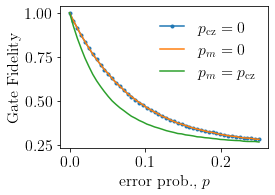

In [8]:
fids_mcz = np.real(np.array(fids_mcz))
fids_cz = np.real(np.array(fids_cz))
fids_m = np.real(np.array(fids_cz))

fsize = 16
font_name = "Times New Roman"
plt.figure(figsize=(4,3))
plt.rcParams['font.size'] = '%d' % (fsize)
plt.rc('text', usetex=True )
plt.rc('font', family=font_name, weight='normal', size=fsize)
plt.rcParams["mathtext.fontset"] = "stix"
plt.plot(pc2_list,fids_m,".-", color="C0", label=r"$p_{{\rm cz}} = 0$")
plt.plot(pc2_list,fids_cz,"-", color="C1",label=r"$p_m =0$")
plt.plot(pc2_list,fids_mcz,"-", color="C2", label=r"$p_m =p_{{\rm cz}}$")

plt.legend(frameon=False,fontsize=fsize,handlelength=1.5)
plt.xlabel("error prob., $p$",fontsize=fsize)
plt.ylabel("Gate Fidelity",fontsize=fsize)
plt.tight_layout()       
# plt.savefig("figs/dv_cnot_fidelity.pdf")
plt.show()

## hadamard 

In [9]:

def cz_err_model(p_c,i_c):
    v_x = np.zeros(2,dtype=int)
    v_z = np.zeros(2,dtype=int)
    if i_c == 1:
        v_x[0] = 1
    elif i_c == 2:
        v_x[0] = 1
        v_z[0] = 1
    elif i_c == 3:
        v_z[0] = 1
    elif i_c == 4:
        v_z[1] = 1
    elif i_c == 5:
        v_x[0] = 1
        v_z[1] = 1
    elif i_c == 6:
        v_x[0] = 1
        v_z = np.ones(2,dtype=int)
    elif i_c == 7:
        v_z = np.ones(2,dtype=int)
    if i_c ==0:
        prob = 1-14*p_c/15
    # elif i_c <= 4:
    #     prob = 2*p_c/15
    else:
        prob = 2*p_c/15
    return v_x, v_z, prob

def hadamard_err_prob_new(p_c,P_m):
    P_h = np.zeros(4) # I, X, Z, Y
    for i_1 in range(8):
        vec_x = np.zeros((4,5),dtype=int)
        vec_z = np.zeros((4,5),dtype=int)
        vec_x[0,0:2], vec_z[0,0:2], p1 = cz_err_model(p_c,i_1)
        for i_2 in range(8):
            vec_x[1,1:3], vec_z[1,1:3], p2 = cz_err_model(p_c,i_2)
            for i_3 in range(8):
                vec_x[2,2:4], vec_z[2,2:4], p3 = cz_err_model(p_c,i_3)
                for i_4 in range(8):
                    vec_x[3,3:5], vec_z[3,3:5], p4 = cz_err_model(p_c,i_4)
                    vec_x_sum = np.sum(vec_x,axis=0) % 2
                    vec_z_sum = np.sum(vec_z,axis=0) % 2
                    for i_0 in range(4):                        
                        xcomp = (np.sum(vec_z_sum[[0,2,3]])+ np.sum(vec_x_sum[[2,3,4]])+ (i_0%2) )%2
                        zcomp = ( np.sum(vec_z_sum[[1,2,4]])+np.sum(vec_x_sum[[1,2]])+ int(i_0/2) )%2

                        P_h[2*zcomp+xcomp] += P_m[i_0]*p1*p2*p3*p4
    return P_h

# pc_list = np.linspace(0,0.001,10)
pc_list = np.linspace(0.0,0.5,50)
P_m = np.zeros(4)

P_tot = np.zeros((4,len(pc_list))) # I, X, Z, Y
for i_p, p_m in enumerate(pc_list):
    p_flip = 2*p_m/3
    p_c = 0
    P_m[0] = (1-p_flip)**4 + 2*p_flip**3 * (1-p_flip) + p_flip**2 * (1-p_flip)**2 
    P_m[1] = 2*p_flip * (1-p_flip)**3 + p_flip**2 * (1-p_flip)**2 + p_flip**4  
    P_m[2] = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
    P_m[3] = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
    P_tot[:,i_p] = hadamard_err_prob_new(p_c,P_m)
inFid_m = 2/3*np.sum(P_tot[1:,:],axis=0)

P_tot = np.zeros((4,len(pc_list))) # I, X, Z, Y
for i_p, p_c in enumerate(pc_list):
    p_flip = 0
    # p_flip = 2*p_c/3
    P_m[0] = (1-p_flip)**4 + 2*p_flip**3 * (1-p_flip) + p_flip**2 * (1-p_flip)**2 
    P_m[1] = 2*p_flip * (1-p_flip)**3 + p_flip**2 * (1-p_flip)**2 + p_flip**4  
    P_m[2] = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
    P_m[3] = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
    P_tot[:,i_p] = hadamard_err_prob_new(p_c,P_m)
inFid_cz = 2/3*np.sum(P_tot[1:,:],axis=0)

P_tot = np.zeros((4,len(pc_list))) # I, X, Z, Y
for i_p, p_c in enumerate(pc_list):
    p_flip = 2*p_c/3
    P_m[0] = (1-p_flip)**4 + 2*p_flip**3 * (1-p_flip) + p_flip**2 * (1-p_flip)**2 
    P_m[1] = 2*p_flip * (1-p_flip)**3 + p_flip**2 * (1-p_flip)**2 + p_flip**4  
    P_m[2] = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
    P_m[3] = p_flip * (1-p_flip)**3 + 2* p_flip**2 * (1-p_flip)**2 + p_flip**3 * (1-p_flip)
    P_tot[:,i_p] = hadamard_err_prob_new(p_c,P_m)
inFid_mcz = 2/3*np.sum(P_tot[1:,:],axis=0)



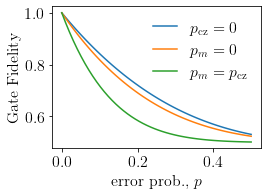

In [11]:
fsize = 16
font_name = "Times New Roman"
plt.figure(figsize=(4,3))
plt.rcParams['font.size'] = '%d' % (fsize)
plt.rc('text', usetex=True )
plt.rc('font', family=font_name, weight='normal', size=fsize)
plt.rcParams["mathtext.fontset"] = "stix"
plt.plot(pc_list,1-inFid_m,"-", color="C0", label=r"$p_{\rm cz} =0$")
plt.plot(pc_list,1-inFid_cz,"-", color="C1",label=r"$p_m =0$")
plt.plot(pc_list,1-inFid_mcz,"-", color="C2", label=r"$p_m =p_{\rm cz}$")


plt.legend(frameon=False,fontsize=fsize,handlelength=1.5)
plt.xlabel("error prob., $p$",fontsize=fsize)
plt.ylabel("Gate Fidelity",fontsize=fsize)
plt.tight_layout()       
# plt.savefig("figs/dv_hadamard_fidelity.pdf")
plt.show()